## Analysing energy changes at sub-global scales

In CMIP5 climate model simulations, drift can lead to substantial non-closure of the global energy budget (i.e. discrepancies between changes in netTOA flux, ocean surface heat flux and ocean heat storage). Foruntately, it has been shown that in most cases this issue can be remedied (i.e. budget closure can be acheived) by dedriting the netTOA, ocean surface heat flux and OHC data ([Hobbs et al 2016](https://journals.ametsoc.org/doi/10.1175/JCLI-D-15-0477.1); [My Anaylsis](https://github.com/DamienIrving/ocean-analysis/blob/master/development/cmip_energy_closure.md)).   

Of course, many analyses are interested in changes to the energy budget at sub-global scales. In general, there are a few different approaches to energy budget analysis at these scales, which I compare and contrast below:
1. Flux integral
2. Linear trend
3. OHC tendency

(I also need to look at the issue of regridding of ocean data.)

In [61]:
import os, sys
import iris
import numpy
import iris.plot as iplt
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context('talk')

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

import general_io as gio
import timeseries
import convenient_universal as uconv


In [62]:
%matplotlib inline

### 1. Flux integral approach

On a global scale, the most common approach to analysing changes in the oceanic energy budget is to plot the change in ocean heat content against the cumulative sum of the ocean surface heat flux (i.e. take the temporal integral of the surface flux to get the corresponding change in heat) (e.g. [Hobbs et al 2016](https://journals.ametsoc.org/doi/10.1175/JCLI-D-15-0477.1); [my anaylsis](https://github.com/DamienIrving/ocean-analysis/blob/master/development/cmip_energy_closure.md)). This approach works well, because any non-zero accumulation of ocean surface heat flux (after dedrifting) will be reflected in the (dedrifted) change in OHC, because in a stationary climate the globally integrated ocean surface heat flux will be zero.

(I think this is essentially the approach that [Frolicher et al (2015)](https://journals.ametsoc.org/doi/abs/10.1175/JCLI-D-14-00117.1) take.)

In [63]:
def calc_anomaly(cube):
    """Calculate the anomaly."""
    
    anomaly = cube.copy()
    anomaly.data = anomaly.data - anomaly.data[0]
    
    return anomaly


def get_data(model):
    """Get the hfds, ohc and hfbasin data"""

    #rndt_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/historical/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-zonal-sum_Ayr_%s_historical_r1i1p1_cumsum-all.nc' %(model, model)
    hfds_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/historical/yr/ocean/r1i1p1/hfds/latest/dedrifted/hfds-zonal-sum_Oyr_%s_historical_r1i1p1_cumsum-all.nc' %(model, model)
    ohc_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/historical/yr/ocean/r1i1p1/ohc/latest/dedrifted/ohc-zonal-sum_Oyr_%s_historical_r1i1p1_all.nc' %(model, model)
    hfbasin_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/historical/yr/ocean/r1i1p1/hfbasin/latest/dedrifted/hfbasin-global_Oyr_%s_historical_r1i1p1_cumsum-all.nc' %(model, model)
    
    time_constraint = gio.get_time_constraint(['1861-01-01', '2005-12-31'])
    
    #rndt_cube = iris.load_cube(rndt_file, 'TOA Incoming Net Radiation' & time_constraint)
    hfds_cube = iris.load_cube(hfds_file, 'surface_downward_heat_flux_in_sea_water' & time_constraint)
    ohc_cube = iris.load_cube(ohc_file, 'ocean heat content' & time_constraint)
    hfbasin_cube = iris.load_cube(hfbasin_file, 'northward_ocean_heat_transport' & time_constraint)
    
    #rndt_anomaly = calc_anomaly(rndt_cube)
    hfds_anomaly = calc_anomaly(hfds_cube)
    ohc_anomaly = calc_anomaly(ohc_cube)
    hfbasin_anomaly = calc_anomaly(hfbasin_cube)
    
    ocean_convergence = ohc_anomaly[-1, ::] - hfds_anomaly[-1, ::]
    
    hfbasin_inferred = ocean_convergence.copy()
    hfbasin_inferred.data = numpy.ma.cumsum(-1 * ocean_convergence.data)
        
    return hfds_anomaly, ohc_anomaly, hfbasin_anomaly, hfbasin_inferred

In [64]:
def plot_uptake_storage(ohc_anomaly, hfds_anomaly):
    """Plot the ocean heat uptake and storage"""

    fig, ax = plt.subplots(figsize=[12, 6])

    iplt.plot(ohc_anomaly[-1, ::], color='blue', label='OHC')
    iplt.plot(hfds_anomaly[-1, ::], color='orange', label='hfds')
    #iplt.plot(convergence, color='green', label='convergence')

    plt.xlabel('latitude')
    plt.ylabel('J')
    plt.xlim(-90, 90)

    plt.axhline(y=0, color='0.5', linestyle='--')

    plt.legend()
    plt.show()

In [65]:
def plot_transport(hfbasin_anomaly_data, hfbasin_anomaly_inferred):
    """Plot the northward ocean heat transport"""

    fig, ax = plt.subplots(figsize=[12, 6])

    iplt.plot(hfbasin_anomaly_data[-1, ::], color='purple', label='northward OHT')
    iplt.plot(hfbasin_anomaly_inferred, color='purple', linestyle='--', label='inferred northward OHT')

    plt.xlabel('latitude')
    plt.ylabel('J')
    plt.xlim(-90, 90)

    plt.axhline(y=0, color='0.5', linestyle='--')

    plt.legend()
    plt.show()

#### GISS-E2-R model

In [66]:
hfds_anomaly, ohc_anomaly, hfbasin_anomaly, hfbasin_inferred = get_data('GISS-E2-R')

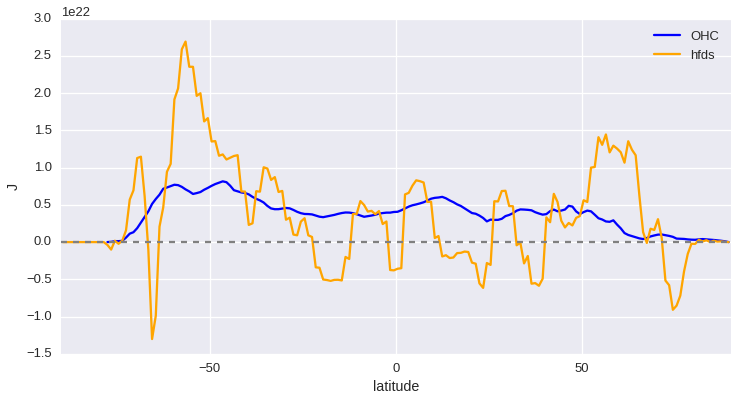

In [67]:
plot_uptake_storage(ohc_anomaly, hfds_anomaly)

In [68]:
ohc_anomaly[-1, ::].data.sum()

6.364347690804366e+23

In [69]:
hfds_anomaly[-1, ::].data.sum()

6.4163868377649319e+23

The OHC and HFDS totals match the [corresponding global timeseries](https://www.flickr.com/photos/69921266@N08/40373452040/). 

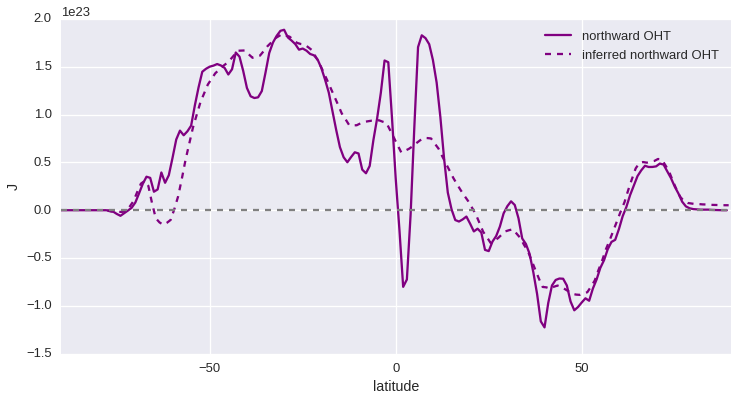

In [70]:
plot_transport(hfbasin_anomaly, hfbasin_inferred)

In [71]:
hfbasin_anomaly[-1, ::].data.sum()

7.1188571928101061e+24

In [72]:
hfbasin_inferred.data.sum()

7.4979635946838421e+24

#### CSIRO-Mk3-6-0 model

In [74]:
hfds_anomaly, ohc_anomaly, hfbasin_anomaly, hfbasin_inferred = get_data('CSIRO-Mk3-6-0')

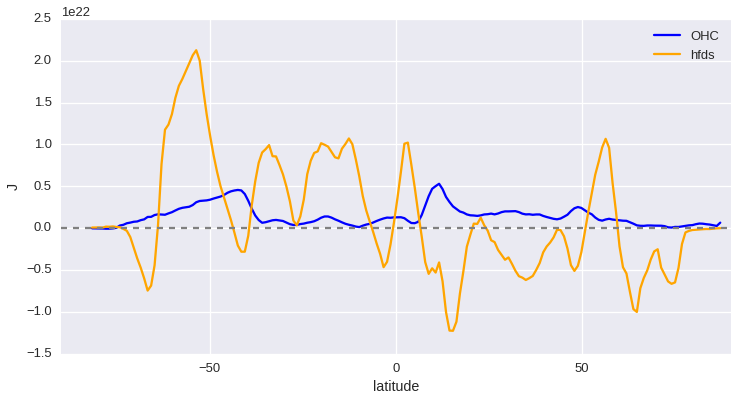

In [75]:
plot_uptake_storage(ohc_anomaly, hfds_anomaly)

In [76]:
ohc_anomaly[-1, ::].data.sum()

2.6108229638745892e+23

In [77]:
hfds_anomaly[-1, ::].data.sum()

2.5853625604736401e+23

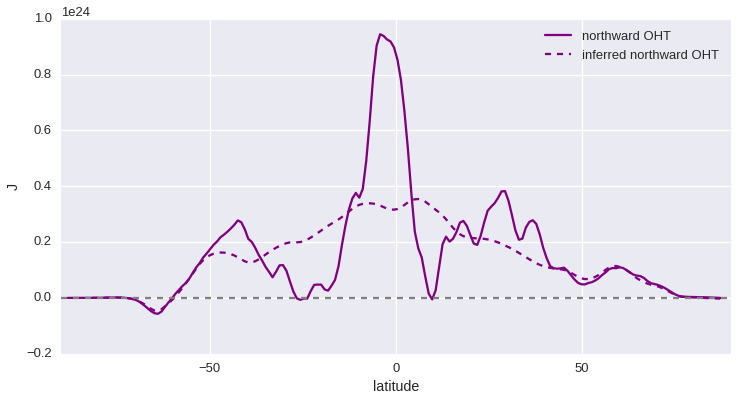

In [78]:
plot_transport(hfbasin_anomaly, hfbasin_inferred)

#### NorESM1-M model

In [79]:
hfds_anomaly, ohc_anomaly, hfbasin_anomaly, hfbasin_inferred = get_data('NorESM1-M')

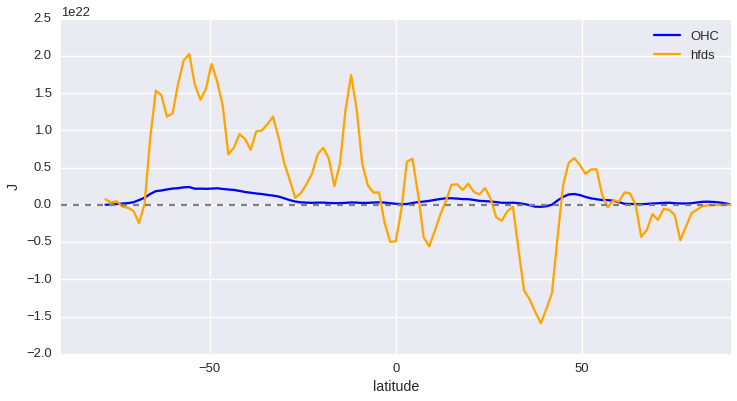

In [80]:
plot_uptake_storage(ohc_anomaly, hfds_anomaly)

In [81]:
ohc_anomaly[-1, ::].data.sum()

8.1186581319855412e+22

In [82]:
hfds_anomaly[-1, ::].data.sum()

3.2877088431042753e+23

The HFDS totals match the [corresponding global timeseries](https://www.flickr.com/photos/69921266@N08/41697247724), but it seems regridding has wrecked the OHC values (the amplitude has dropped appreciably).

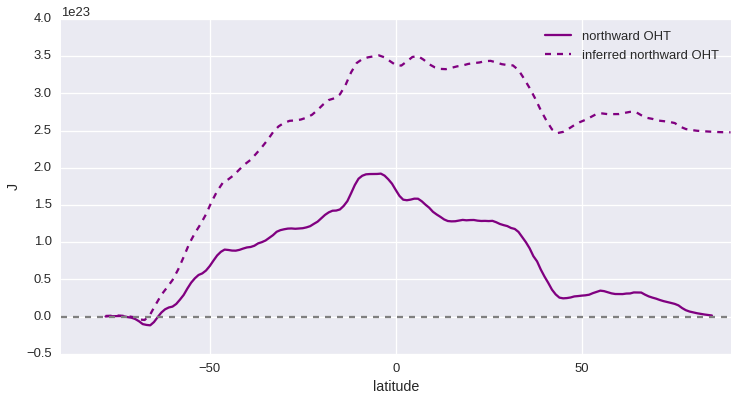

In [83]:
plot_transport(hfbasin_anomaly, hfbasin_inferred)

### 2.  Linear trend

This is often the approach taken when looking at a single aspect of the energy budget in isolation (e.g. Shi et al, submitted). My [preliminary results](https://www.authorea.com/users/5641/articles/211791-exploring-the-ocean-response-to-anthropogenic-forcing) are presented as linear trends.

### 3. OHC tendency

This is the approach taken by [Nummelin et al (2017)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2016GL071333). I look at it in some detail [here](https://www.authorea.com/users/5641/articles/176078-replicating-nummelin-et-al-2017/_show_article).